# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms
from PIL import Image
import torch
import torch.nn as nn
import random 

In [2]:
image_directory = "/Users/ethanlewis/Desktop/Lettuce NPK/FNNPK"     # Dataset
npk_model_3 = "/Users/ethanlewis/Desktop/Lettuce NPK/npk_model_3.pth"   # Saved Model Path

# Lettuce NPK

## Image Samples

Image labels correspond to respective nutrient deficiency:
- **FN:** Fully Nutritional
- **-N:** Nitrogen Deficient 
- **-P:** Phosphorus Deficient 
- **-K:** Potassium Deficient

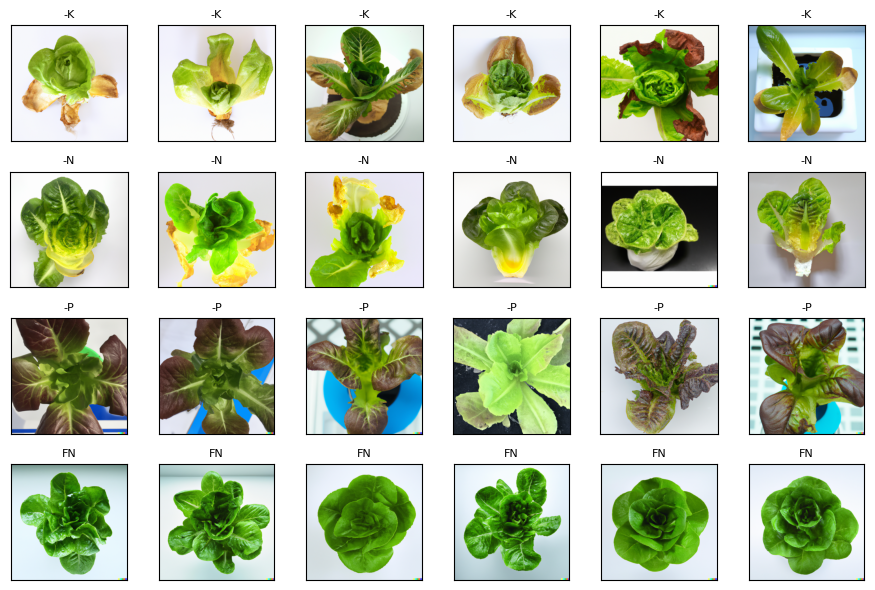

In [3]:
# Get class names and skip non-directories (like .DS_Store)
class_names = [name for name in sorted(os.listdir(image_directory)) 
               if os.path.isdir(os.path.join(image_directory, name))]

nrows = len(class_names)
ncols = 6

plt.figure(figsize=(ncols * 1.5, nrows * 1.5))

# Loop through class folders and images
for row in range(nrows):
    class_name = class_names[row]
    img_paths = [os.path.join(image_directory, class_name, filename)
                 for filename in os.listdir(os.path.join(image_directory, class_name))
                 if not filename.startswith('.')]  # Skip hidden files

    for col in range(min(ncols, len(img_paths))):  # Ensure no index error
        plt.subplot(nrows, ncols, row * ncols + col + 1)
        img = plt.imread(img_paths[col])
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(class_name, fontsize=8)

plt.tight_layout()
plt.show()

## Data Preprocessing

In [4]:
# Ubiquitous Image Transformations
transform = transforms.Compose([transforms.Resize(255, antialias=True),     # Resize shorter edge to 255 pixels while maintaining aspect ratio. Smooth image. 
                                transforms.CenterCrop(224),                 # Crop image to 224x224 pixels from the center (Resnet-50)
                                transforms.RandomRotation(180),             # Random rotation (up to 180 degrees)
                                transforms.ToTensor(),])                    # Convert to Tensor object (normalized pixel values)

# Load Data
dataset = datasets.ImageFolder(image_directory, transform=transform)        # Creates class labels: FN, -N, -P, -K

print("Classes:", dataset.classes)
print("Class Labels:", [dataset.class_to_idx[c] for c in dataset.classes])
print("Number of Images:", len(dataset.imgs))
print(dataset.imgs[0])                                                      # (Image Path, Class Label)

Classes: ['-K', '-N', '-P', 'FN']
Class Labels: [0, 1, 2, 3]
Number of Images: 208
('/Users/ethanlewis/Desktop/Lettuce NPK/FNNPK/-K/k_1.png', 0)


## Data Preprocessing (Example)

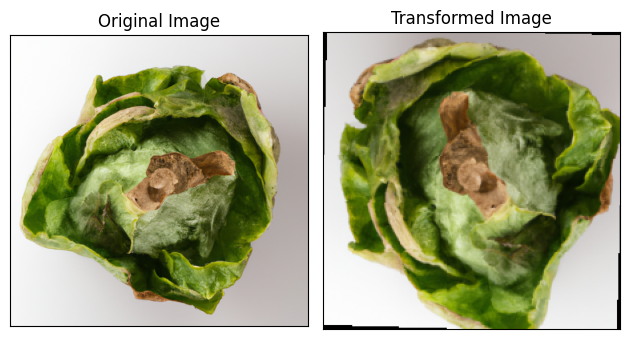

In [5]:
img_path, label = dataset.imgs[2]                               # Sample 3rd Image                 
original_img = Image.open(img_path)
transformed_img = transform(original_img)
imgs = [original_img, transformed_img]

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(np.asarray(original_img))
plt.xticks([])
plt.yticks([])
plt.title("Original Image")

# Transformed Image
plt.subplot(1, 2, 2)
transformed_img = torch.moveaxis(transformed_img, 0, -1)        # Convert Tensor object format to Matplotlib compatability (3,224,224) -> (224,224,3)
plt.imshow(np.asarray(transformed_img))
plt.xticks([])
plt.yticks([])
plt.title("Transformed Image")
plt.tight_layout()
plt.show()

# EDA

## Class Labels
- **-K:** 0 
- **-N:** 1  
- **-P:** 2  
- **FN:** 3 

## Class Distribution

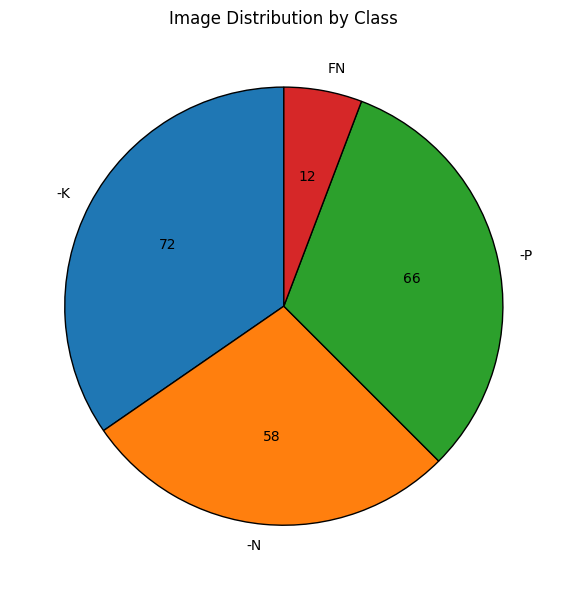

In [6]:
# Calculate the number of images per class
class_counts = {class_name: len(os.listdir(os.path.join(image_directory, class_name))) 
                for class_name in dataset.classes}

# Function to display the counts instead of percentages
def autopct_format(values):
    def inner_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{count}'
    return inner_autopct

# Create the Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(
    class_counts.values(), 
    labels=class_counts.keys(), 
    autopct=autopct_format(class_counts.values()), 
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Image Distribution by Class')
plt.tight_layout()
plt.show()

# Module 3 Camera Sample Image

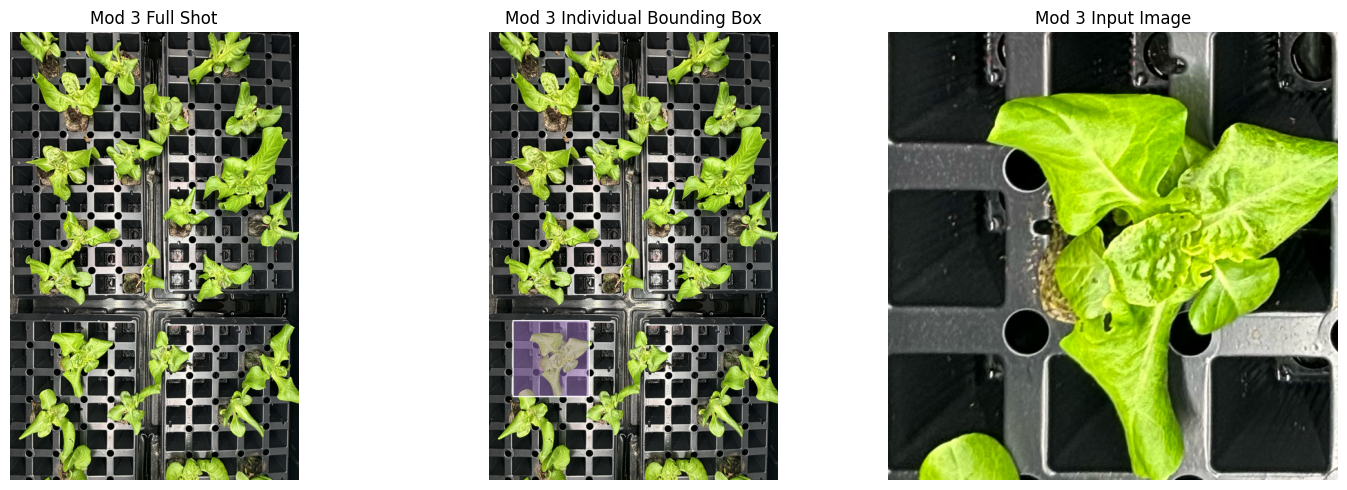

In [7]:
# Load your images
mod3_full = Image.open("/Users/ethanlewis/Desktop/Arduino Pics/Module 3 Full.jpg")
mod3_box = Image.open("/Users/ethanlewis/Desktop/Arduino Pics/Individual Bounding Box.jpg")
mod3 = Image.open("/Users/ethanlewis/Desktop/Arduino Pics/Module 3 Pic.jpg")

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figure size as needed

# Display each image in its respective subplot
images = [mod3_full, mod3_box, mod3]
titles = ["Mod 3 Full Shot", "Mod 3 Individual Bounding Box", "Mod 3 Input Image"]

for i, ax in enumerate(axes):
    ax.imshow(np.asarray(images[i]))  # Convert to NumPy array for display
    ax.set_title(titles[i], fontsize=12)  # Add title
    ax.axis('off')  # Remove axes ticks

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [8]:
mod3.size

(652, 649)

- The raw input image in our application will ultimately be 652 x 649 pixels. 
- Keep this in mind when applying transformations to training set to mimic realistic conditions of application.

# Transformation Playground

There are several key differences between the Lettuce NPK dataset images and the images the unit camera will ultimately caprture and use as input in our application. I intend to account for/ minimize these differences through a series of unique transformations...

#### **Background**

The majority of images in the NPK dataset feature a vivid white or black background. We know the background of our Mod3 images are mostly black (however there are several light and depth variations). 

I would like to converge all image backgrounds to some neutral and realistic RGB value to bring sole focus to the lettuce leaves in frame...

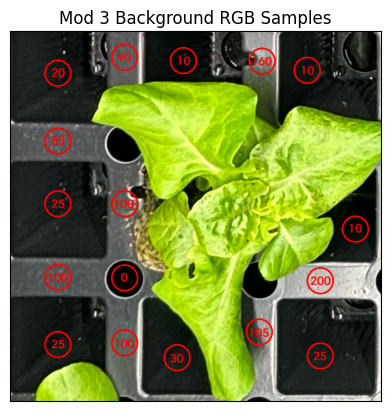

In [9]:
mod3_background = Image.open("/Users/ethanlewis/Desktop/Arduino Pics/Module 3 Background.jpg")
plt.imshow(np.asarray(mod3_background))
plt.xticks([])
plt.yticks([])
plt.title("Mod 3 Background RGB Samples")
plt.show()

Using Photoshop, I sampled 17 regions of our Mod3 image background to identify their RGB values. The average of these 17 samples was 64, so I will look to convert any extreme white or black pixel values in every image to 64 (dark grey).

The following function converts all pixel values in an image > 160 (extreme white) and < 30 (extreme black) to our neutral value of 64...

In [10]:
# Custom class to convert near-white pixels to black and near-black pixels to [64, 64, 64]
class ConvertWhiteAndBlackPixels:
    def __call__(self, img):
        # Ensure the image is in RGB mode
        img = img.convert("RGB")

        # Convert the image to a NumPy array for pixel manipulation
        img_array = np.array(img)

        # Define thresholds
        white_threshold = 160  # Pixels above this threshold in all channels are considered near-white
        black_threshold = 30   # Pixels below this threshold in all channels are considered near-black

        # Create masks
        white_mask = (img_array >= white_threshold).all(axis=-1)  # Near-white mask
        black_mask = (img_array <= black_threshold).all(axis=-1)  # Near-black mask

        # Apply transformations
        img_array[white_mask] = [64, 64, 64]      # Set near-white pixels to black
        img_array[black_mask] = [64, 64, 64]   # Set near-black pixels to [64, 64, 64]

        # Convert the modified array back to a PIL image
        return Image.fromarray(img_array)

#### **Color**

A quick visual inspection the NPK dataset images and their corresponding class labels leads me to believe the distinctive coloring on the lettuce leaves may be extremley indicative of which nutrient deficiency category the plant falls into. With this in mind I would like to slightly increase the brightness, contrast, saturation, and hue of each image to really pronounce these color variations. 

**It is important to keep in mind we do not want to alter the 64RGB background pixels created by the previous function**

The following function randomly increases the image's brightness, contrast, saturation, and hue within a defined range, but it *does not* apply this transformation to any pixels inside the image with an RGB value of 64.

In [11]:
# Custom function to only increase ColorJitter parameters 
def positive_color_jitter(img):
    """Apply only positive increases to brightness, contrast, saturation, and hue."""
    # Define fixed increase factors
    brightness_factor = 1 + random.uniform(0, 0.1)  # Brightness: 0-10% increase
    contrast_factor = 1 + random.uniform(0, 0.2)    # Contrast: 0-20% increase
    saturation_factor = 1 + random.uniform(0, 0.2)  # Saturation: 0-20% increase
    hue_factor = random.uniform(0, 0.02)            # Hue shift: 0-2%

    # Apply transformations one by one
    img = transforms.functional.adjust_brightness(img, brightness_factor)
    img = transforms.functional.adjust_contrast(img, contrast_factor)
    img = transforms.functional.adjust_saturation(img, saturation_factor)
    img = transforms.functional.adjust_hue(img, hue_factor)

    return img


# New function to apply jitter only to non-black (lettuce) pixels
def apply_jitter_to_leaves(img):
    """Apply color jitter only to non-black pixels."""
    # Convert image to numpy array
    img_np = np.array(img)

    # Create a mask for non-black pixels (i.e., lettuce pixels)
    mask = np.any(img_np != [64, 64, 64], axis=-1)

    # Apply jitter to the entire image
    jittered_img = positive_color_jitter(img)

    # Replace only non-black pixels with the jittered version
    img_np[mask] = np.array(jittered_img)[mask]

    # Convert back to PIL image
    return Image.fromarray(img_np)

#### **Image Size**

All images in the NPK dataset are roughly sized 1024x1000 pixels, while the input image in our application is only sized 652x649 pixels. An obvious first step is to resize all NPK images to these dimensions to arrive at a realistic input image starting point. 

Additionally, the ResNet50 backbone recommends resizing input images to 255 pixels (short side), so I will also perform this transformation. It is not clear to me whether there is any tangible difference between first resizing to 652x649 and then to 255 rather than directly resizing to 255. Given I want to simulate the most realistic input image possible, I will sequentially perform both of these resizings to the NPK images.

#### **Perspective**

It is clear all images in the NPK dataset were individually captured from a top-down perspective; this is not the case for our Mod3 images. While the Mod3 camera certianly provides an aerial view, it is mounted over a tray of 25 lettuce plants, meaning some of the plants on the edges of the frame may have a slightly skewed perspective. 

Accounting for this can easily be achieved by applying a minimal, RandomPerspective() shift to the NPK images. 

#### **Crop**

We know ResNet50 ultimately requires a 224x224 pixel input image. As we previosuly discussed, the NPK images have the luxury of being uniformly captured from the top-down, and can simply perform a CenterCrop() to create images with lettuce plants in the dead center of the image frame. 

Simply looking at our full boudnign box layout below, it is clear not all of the Mod3 images will perfectly center the plants in frame.

To simulate this effect, we can perform a RandomCrop() instead to force some of the training images to have their plants shifted from the center of the frame. 

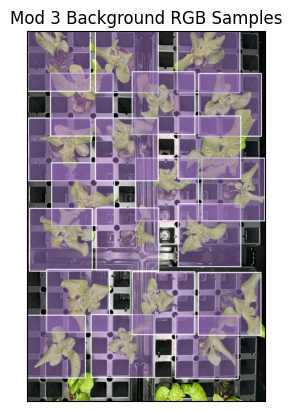

In [12]:
mod3_boxes = Image.open("/Users/ethanlewis/Desktop/Arduino Pics/Full Bounding Box Layout.jpg")
plt.imshow(np.asarray(mod3_boxes))
plt.xticks([])
plt.yticks([])
plt.title("Mod 3 Background RGB Samples")
plt.show()

## Data Preprocessing

### NPK Transformations

In [13]:
# Transformation Pipeline
transform = transforms.Compose([ConvertWhiteAndBlackPixels(),                                           # Convert background to neutral, 64RGB
                                transforms.Resize((652,649), antialias=True),                           # Resize image to Mod3 input image size
                                transforms.Resize(255, antialias=True),                                 # Resize image based on ResNet-50 recommendation
                                transforms.RandomPerspective(distortion_scale=0.25, p=0.5, fill=64),    # Perform random perspective shift, fill disiplaced pixels with 64RGB
                                transforms.RandomCrop(224),                                             # Randomly crop to 224x224 pixel image 
                                apply_jitter_to_leaves,                                                 # Adjust color levels of the plant
                                transforms.ToTensor(),])                                                # Convert to Tensor object (normalized pixel values)

# Load Data
dataset = datasets.ImageFolder(image_directory, transform=transform)

print("Classes:", dataset.classes)
print("Class Labels:", [dataset.class_to_idx[c] for c in dataset.classes])
print("Number ofIimages:", len(dataset.imgs))
print(dataset.imgs[0])  # (Image Path, Class Label)

Classes: ['-K', '-N', '-P', 'FN']
Class Labels: [0, 1, 2, 3]
Number ofIimages: 208
('/Users/ethanlewis/Desktop/Lettuce NPK/FNNPK/-K/k_1.png', 0)


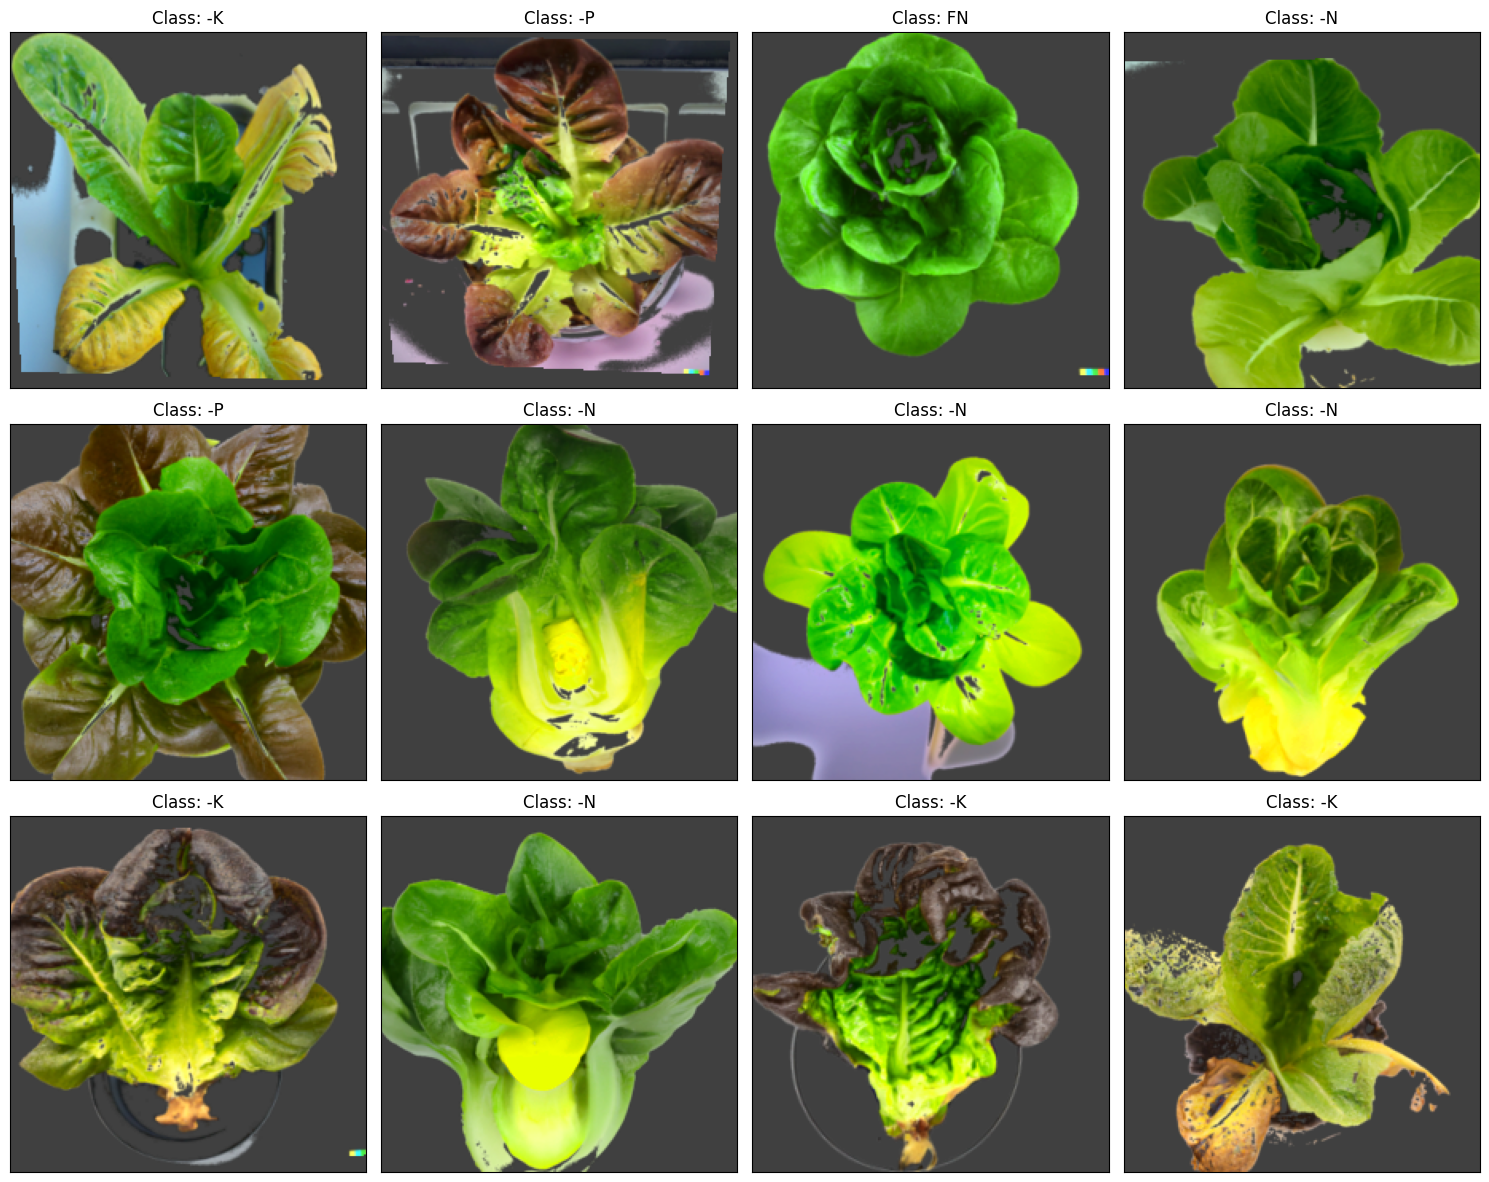

In [14]:
# Select a random sample of images
num_images = 12  # Number of images to display
random_indices = random.sample(range(len(dataset)), num_images)  # Random indices

# Set up the grid layout
ncols = 4  # Number of columns in the grid
nrows = (num_images + ncols - 1) // ncols  # Calculate rows required

# Create a Matplotlib figure
plt.figure(figsize=(15, nrows * 4))  # Adjust size for better display

for i, idx in enumerate(random_indices):
    # Load and transform the image
    img_path, label = dataset.imgs[idx]
    transformed_img = dataset[idx][0]  # Get the transformed image (as a tensor)

    # Adjust tensor shape for Matplotlib compatibility (C, H, W) -> (H, W, C)
    transformed_img = torch.moveaxis(transformed_img, 0, -1)

    # Display the transformed image in the grid
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(np.asarray(transformed_img))
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Class: {dataset.classes[label]}")

plt.tight_layout()
plt.show()

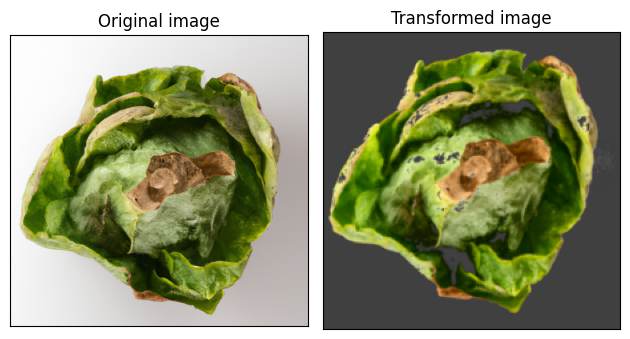

In [15]:
img_path, label = dataset.imgs[2]
original_img = Image.open(img_path)
transformed_img = transform(original_img)
imgs = [original_img, transformed_img]

plt.subplot(1, 2, 1)
plt.imshow(np.asarray(original_img))
plt.xticks([])
plt.yticks([])
plt.title("Original image")
plt.subplot(1, 2, 2)
transformed_img = torch.moveaxis(transformed_img, 0, -1) # change shape from (3, 224, 224) to (224, 224, 3)
plt.imshow(np.asarray(transformed_img))
plt.xticks([])
plt.yticks([])
plt.title("Transformed image")
plt.tight_layout()
plt.show()

### Mod3 Transformations

In [16]:
# Ubiquitous Image Transformations
transform3 = transforms.Compose([ConvertWhiteAndBlackPixels(),                  # Convert white background to black to mimic unit environment
                                transforms.Resize((224,224), antialias=True),   # Resize to 224x224 pixel requirement (ResNet50)
                                transforms.ToTensor(),])                        # Convert to Tensor object (normalized pixel values)

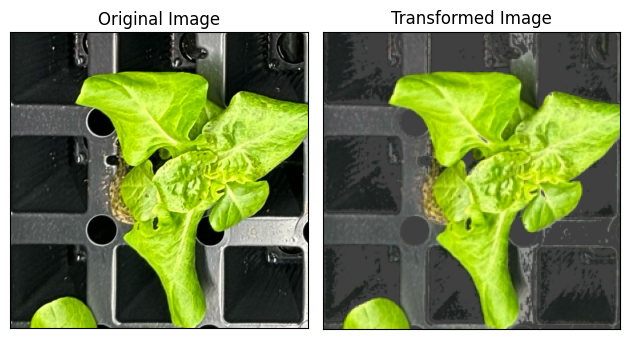

In [17]:
original_img = mod3
transformed_img = transform3(original_img)
imgs = [original_img, transformed_img]

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(np.asarray(original_img))
plt.xticks([])
plt.yticks([])
plt.title("Original Image")
plt.subplot(1, 2, 2)

# Transformed Image
transformed_img = torch.moveaxis(transformed_img, 0, -1)        # Convert Tensor object format to Matplotlib compatability (3,224,224) -> (224,224,3)
plt.imshow(np.asarray(transformed_img))
plt.xticks([])
plt.yticks([])
plt.title("Transformed Image")
plt.tight_layout()
plt.show()

## Summary

Visualily comparing the results of our transformations on the NPK images to the anticipated (application) appearance of our Mod3 image, it seems we have acheived a reasonable level of similarity between the images originating from two distinct sources. This should serve as a good framework to ultimately train on the NPK dataset and easily apply transfer learning to our own application. 

# ResNet-50 Transfer Learning

### Setup

In [18]:
from torchvision.models import resnet50, ResNet50_Weights

# Use GPU if available
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device

'cpu'

### Load Pre-Trained ResNet-50 Model

This funciton...
- Initializes the ResNet-50 model with pre-trained ImageNet weights.
- Alters final, fully connected layer to fit classification task with 4 classes.
- Adds ReLU for non-linearity and softmaxing for probability outputs.

In [19]:
# Loads a pre-trained ResNet-50 model and customizes the final fully connected layer to classify 4 classes (instead of the original 1,000 ImageNet classes).
def get_resnet50():
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)        # Initialize model with pretrained weights from ImageNet
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(model.fc.in_features, 100),                 # Create linear layer taking 2048 input features and outputting 100 features
        torch.nn.ReLU(),                                            # ReLU activation function to introduce non-linearity
        torch.nn.Linear(100, 4),                                    # Create linear layer to map 100 input features to 4 output classes (FN, -N, -P, -K)
        torch.nn.Softmax()                                          # Convert outputs to probabiiltes 
    )
    return model

### Model Fine-Tuning

Function inputs...
- **model:** neural-network model to be fine-tuned
- **epochs:** number of epochs (iterations) for training
- **train_dataloader:** DataLoader for training set; provides mini-batches of data
- **optimizer:** optimizer used to update model weights
- **loss_function:** function to compute loss (i.e. cross-entropy)
- **val_dataloader:** DataLoader for validation set **(Optional)**
- **checkpoint_epochs:** tracks model checkpoints **(Unused)**
- **max_epochs_without_imp:** max number of epochs without improvement prior to early stopping **(2)**

This funciton...
- Tracks training (and validation) set loss and accuracy over epochs.
- Updates weights using gradient descent and an optimizer.
- Supports early stopping if model stops improving. 
- Evaluates model using validation set (if provided).

In [20]:
def finetune(model, epochs, train_dataloader, optimizer, loss_function, val_dataloader=None, checkpoint_epochs=5, max_epochs_without_imp=2):
  
# Storage for loss and accuracy values over all epochs (training and validation)
  history = {
      "loss": {
          "train": [],
          "val": []
      },
      "accuracy": {
          "train": [],
          "val": []
      }
  }

# TRAINING LOOP (Over specified number of epochs)
  for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}", end="\t-\t")

    model.train()   # Put model in training mode to enable dropout and batch normalization
    train_loss = torch.tensor(0., device=device)        # Loss for the curent batch are set to 0
    train_accuracy = torch.tensor(0., device=device)    # Accuracy for the curent batch are set to 0

    # Training data iteration
    for X, y in train_dataloader:
      X = X.to(device)      # Images
      y = y.to(device)      # Labels
      ypred = model(X)      # Predictions
      loss = loss_function(ypred, y)    # Computes loss using specifed loss_funciton
      optimizer.zero_grad() # Clear previous gradient
      loss.backward()       # Compute gradient via backpropagation
      optimizer.step()      # Update model parameters using computed gradients
      
      # Accumulating loss and accuracy for current epoch
      with torch.no_grad():
        train_loss += loss*train_dataloader.batch_size
        train_accuracy += (torch.argmax(ypred, dim=1) == y).sum()

    # Record and store average loss and accuracy of the current epoch
    history["loss"]["train"].append(train_loss.item()/len(train_dataloader.dataset))
    history["accuracy"]["train"].append(train_accuracy.item()/len(train_dataloader.dataset))
    print(f"train loss: {history['loss']['train'][-1]:.2f}", end=", ")
    print(f"train acc: {history['accuracy']['train'][-1]:.2f}", end="\t-\t")

    # VALIDATION SET (if provided)
    if val_dataloader is not None:
      model.eval()      # Set model to evaluation mode
      val_loss = torch.tensor(0., device=device)        # Loss for the curent batch are set to 0
      val_accuracy = torch.tensor(0., device=device)    # Accuracy for the curent batch are set to 0

      # VALIDATION LOOP
      with torch.no_grad():
        for X, y in val_dataloader:
          X = X.to(device)  # Images
          y = y.to(device)  # Labels
          ypred = model(X)  # Prediction
          loss = loss_function(ypred, y)    # Computes loss using specifed loss_funciton
          # Accumulating loss and accuracy for current epoch
          val_loss += loss * val_dataloader.batch_size
          val_accuracy += (torch.argmax(ypred, dim=1) == y).sum()

      # Record and store average loss and accuracy of the current epoch
      history["loss"]["val"].append(val_loss.item()/len(val_dataloader.dataset))
      history["accuracy"]["val"].append(val_accuracy.item()/len(val_dataloader.dataset))
      print(f"val loss: {history['loss']['val'][-1]:.2f}", end=", ")
      print(f"val acc: {history['accuracy']['val'][-1]:.2f}")


  return model, history     # Return fine-tuned model and training/ validation history

# Training

We know class imbalance exists in our dataset (see pie chart). *WeightedRandomSampler* ensures each class is sampled inversely proportional to its frequency to help the model see a more balanced batch of classes during training to improve generalization.

In [21]:
from torch.utils.data import WeightedRandomSampler

In [22]:
# Create training, validation, and test set splits (80%, 10%, 10%)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, (0.8, 0.1, 0.1))

train_labels = [label for _, label in np.array(dataset.imgs)[train_set.indices]]    # Extract class labels corresponding to training_set indices

class_counts = dict(zip(*np.unique(train_labels, return_counts=True)))              # Track class distribution 
samples_weights = np.array([1/class_counts[label] for label in train_labels])       # Inversely proportional class sampling function 

# Draw Samples
samples_weights = torch.from_numpy(samples_weights).double()
sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

# TRAINING SET DataLoader
# 16 images in each batch | 4 worker threads to load data in parallel 
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, num_workers=0, pin_memory=True, sampler=sampler)


# Identical to above code, but for VALIDATION SET
val_labels = [label for _, label in np.array(dataset.imgs)[val_set.indices]]
class_counts = dict(zip(*np.unique(val_labels, return_counts=True)))
samples_weights = np.array([1/class_counts[label] for label in val_labels])
samples_weights = torch.from_numpy(samples_weights).double()
sampler = WeightedRandomSampler(samples_weights, len(samples_weights))
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=16, num_workers=0, pin_memory=True, sampler=sampler)

A smaller learning rate is used for Layers 3 and 4 to smoothly update their pre-trained weights. 
- Lower layers contain general-purpose features and do not need large updates.
- A smaller learning rate prevents these layers from "forgetting" what they've learned from ImageNet.

A larger learning rate is user for the FC Lyaer since its weights are learned from scratch.
- Higher layers are more task-specific and require larger updates to adapt to the custom dataset.

In [23]:
model = get_resnet50().to(device)   # Load pre-trained ResNet-50 model

weight_decay = 1e-4     # Regulariztion param to prevent overfitting (Penalizes large weights)
epochs = 25             # Number of iterations over training set

# Initialize Adam optimizer (momentum + adaptive learning for faster convergence)
optimizer = torch.optim.Adam(
    [
        {"params": model.layer3.parameters(), "lr": 1e-4},  # Set learning rate of Layer 3 to 1e-4
        {"params": model.layer4.parameters(), "lr": 1e-4},  # Set learning rate of Layer 3 to 1e-4
        {"params": model.fc.parameters(), "lr": 1e-3},      # Set learning rate of Fully Connected Layer to 1e-3
    ],
    weight_decay=weight_decay   # Prevent overfitting
)

# Utilize a Cross Entropy Loss Function to compute loss
# Commonly used for multi-class classification tasks; compares predicted class probabilities to ground truth and penalizes incorrect predictions
loss_function = torch.nn.CrossEntropyLoss()

# Train and fine-tune the model
model, history = finetune(model, epochs, train_dataloader, optimizer, loss_function, val_dataloader=val_dataloader)

Epoch 1/25	-	

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


train loss: 1.41, train acc: 0.42	-	val loss: 2.00, val acc: 0.33
Epoch 2/25	-	train loss: 1.12, train acc: 0.77	-	val loss: 1.63, val acc: 0.76
Epoch 3/25	-	train loss: 1.00, train acc: 0.81	-	val loss: 1.49, val acc: 0.71
Epoch 4/25	-	train loss: 0.88, train acc: 0.93	-	val loss: 1.27, val acc: 0.95
Epoch 5/25	-	train loss: 0.91, train acc: 0.89	-	val loss: 1.39, val acc: 0.81
Epoch 6/25	-	train loss: 0.84, train acc: 0.96	-	val loss: 1.27, val acc: 0.86
Epoch 7/25	-	train loss: 0.83, train acc: 0.96	-	val loss: 1.42, val acc: 0.86
Epoch 8/25	-	train loss: 0.83, train acc: 0.96	-	val loss: 1.38, val acc: 0.86
Epoch 9/25	-	train loss: 0.83, train acc: 0.96	-	val loss: 1.28, val acc: 0.95
Epoch 10/25	-	train loss: 0.81, train acc: 0.98	-	val loss: 1.27, val acc: 0.95
Epoch 11/25	-	train loss: 0.85, train acc: 0.95	-	val loss: 1.48, val acc: 0.76
Epoch 12/25	-	train loss: 0.81, train acc: 0.99	-	val loss: 1.15, val acc: 1.00
Epoch 13/25	-	train loss: 0.79, train acc: 1.00	-	val loss: 1.

# Training Results

### Accuracy Plot

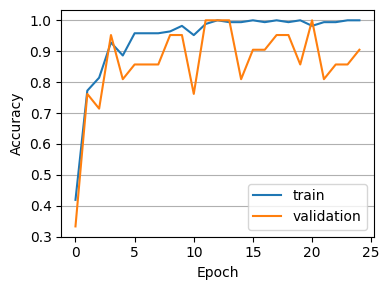

In [24]:
plt.figure(figsize=(4, 3))
plt.plot(history["accuracy"]["train"], label="train")
plt.plot(history["accuracy"]["val"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(axis="y")
plt.legend()
plt.tight_layout()
plt.show()

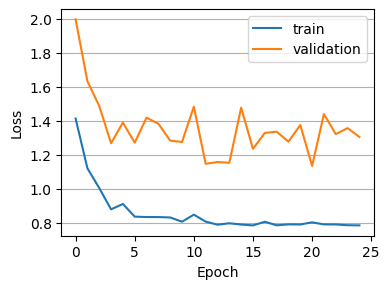

In [25]:
plt.figure(figsize=(4, 3))
plt.plot(history["loss"]["train"], label="train")
plt.plot(history["loss"]["val"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(axis="y")
plt.legend()
plt.tight_layout()
plt.show()

### Save the Model

In [26]:
torch.save(model, npk_model_3)

# Model Evaluation

### Test Set Accuracy

In [27]:
# Load trained model and set to evaluation mode (disable dropout and batch normalization)
saved_model = torch.load(npk_model_3)
saved_model.eval()

# Generate predicitions on test set images
with torch.no_grad():
    preds = saved_model(torch.stack([x for x, y in test_set]).to(device)).cpu().detach().numpy()

test_labels = np.array([int(label) for _, label in np.array(dataset.imgs)[test_set.indices]])   # Extract test set ground truth lables 
predicted_labels = np.argmax(preds, axis=1)                                                     # Convert predicted probabiites to corresponding class label
accuracy = len(np.where(test_labels==predicted_labels)[0])/len(test_labels)                     # Calculate test accuracy rate
print("Model accuracy on the test set: {:.2f}".format(accuracy))                                # Print test accuracy rate

Model accuracy on the test set: 0.95


### Visualize Results

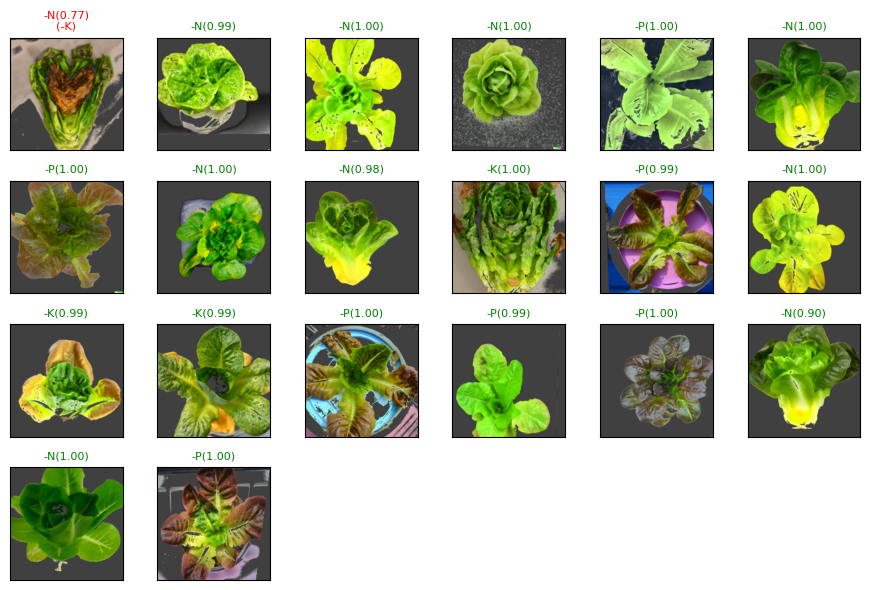

In [28]:
# Create a mapping from class labels to class names
classes = dataset.classes
class_names = dict(zip(range(len(classes)), sorted(classes)))

nrows = 4  # Number of rows for plotting
ncols = 6  # Number of columns for plotting

# Limit the number of images to the smaller of nimgs or the test set size
nimgs = min(nrows * ncols, len(test_set.indices))  # Ensure we don't exceed available images

plt.figure(figsize=(ncols * 1.5, nrows * 1.5))

for i in range(nimgs):
    # Load image and label from the transformed dataset
    img, label = dataset[test_set.indices[i]]
    label = int(label)
    class_name = class_names[label]
    pred_label, confidence = np.argmax(preds[i]), max(preds[i])
    pred_class_name = class_names[pred_label]

    # Adjust tensor shape for plotting: (C, H, W) -> (H, W, C)
    img = torch.moveaxis(img, 0, -1).numpy()

    # Plot transformed image
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(
        f"{pred_class_name}({confidence:.2f})" if pred_label == label else \
        f"{pred_class_name}({confidence:.2f})\n({class_name})",
        fontsize=8, color="green" if pred_label == label else "red"
    )

plt.tight_layout()
plt.show()

# Transfer Learning Prediction Funciton

In [29]:
def prediction(img):
    new_img = transform3(img)
    model.eval()
    with torch.no_grad():
        pred = model(torch.stack([new_img]).to(device)).cpu().detach().numpy()[0]
    class_label = np.argmax(pred)
    return class_names[np.argmax(pred)], pred[class_label]

prediction(mod3)

('-N', 0.5435241)

In [30]:
train_set

In [31]:
from collections import Counter

# Assuming train_set is your Subset object
# Retrieve labels for each sample in the Subset by accessing the original dataset
train_labels = [train_set.dataset.targets[idx] for idx in train_set.indices]

# Count the occurrences of each class label
class_counts = Counter(train_labels)

# Display class counts
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples")

Class 2: 54 samples
Class 3: 12 samples
Class 1: 45 samples
Class 0: 56 samples


In [33]:
from collections import Counter

# Assuming train_set is your Subset object
# Retrieve labels for each sample in the Subset by accessing the original dataset
train_labels = [val_set.dataset.targets[idx] for idx in val_set.indices]

# Count the occurrences of each class label
class_counts = Counter(train_labels)

# Display class counts
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples")

Class 0: 12 samples
Class 1: 4 samples
Class 2: 5 samples


In [34]:
from collections import Counter

# Assuming train_set is your Subset object
# Retrieve labels for each sample in the Subset by accessing the original dataset
train_labels = [test_set.dataset.targets[idx] for idx in test_set.indices]

# Count the occurrences of each class label
class_counts = Counter(train_labels)

# Display class counts
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples")

Class 0: 4 samples
Class 1: 9 samples
Class 2: 7 samples
